In [92]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, BatchNormalization, Dropout
from keras.utils import to_categorical

## 1) The Dataset

#### Assuming you have a classification problem, is it binary, multi-class or multi-label?

I have a multi-class classification problem.

In [93]:
path = 'data/datasets-resized'

#Loading images from folder
import glob
import cv2
from skimage import io
from skimage.transform import resize

types = ['*.jpg', '*.jpeg']

#Creating list images and labels
images = []
labels = []

# Iterate the folder with glob
for fpath in glob.glob(path + '/*.jpg'): 
    # Read the image with OpenCV    
    im = cv2.imread(fpath) 
    im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    # Assigning labels to images
    if 'glass' in fpath:
        label = 0 
    elif 'metal' in fpath:
        label = 1
    elif 'paper' in fpath:
        label = 2 
    elif 'plastic' in fpath:
        label = 3
    elif 'cardboard' in fpath:
        label = 4
        
    im_rgb = cv2.resize(im_rgb, (128, 128))
    #Put image array to X    
    #Put label to y    
    images.append(im_rgb)
    labels.append(label)
    
#Convert X and y to numpy array
images = np.array(images)
labels = np.array(labels)

#### Train/Test sizes- Image size?

In [94]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, train_size=0.8)

In [95]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1913, 128, 128, 3), (1913,), (479, 128, 128, 3), (479,))

#### Show a few examples per class

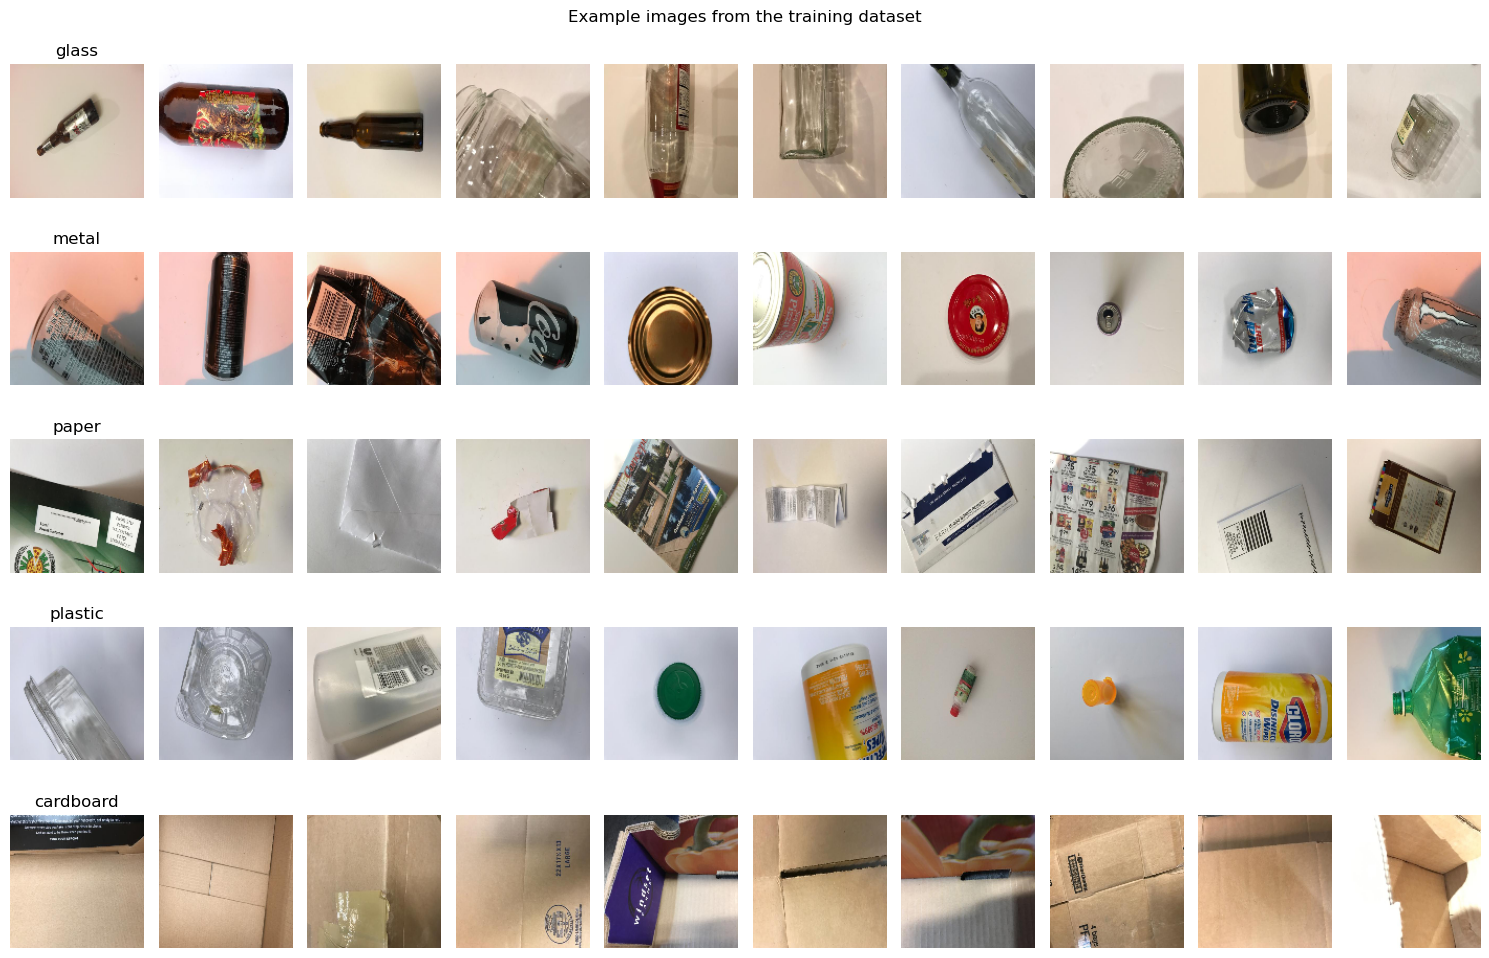

In [96]:
# Define the class names
class_names = ["glass", "metal", "paper", "plastic", "cardboard"]

# Identify the different classes in the dataset
num_classes = len(class_names)
class_indices = [np.where(y_train == i)[0] for i in range(num_classes)]

# Select 10 example images for each class
num_examples = 10
fig, axes = plt.subplots(num_classes, num_examples, figsize=(15, 10))

for i in range(num_classes):
    for j in range(num_examples):
        # Select a random image index from the current class
        idx = np.random.choice(class_indices[i])
        # Display the image
        axes[i, j].imshow(X_train[idx])
        axes[i, j].axis("off")
        # Add the class label as the title
        if j == 0:
            axes[i, j].set_title(class_names[i])
            
plt.suptitle("Example images from the training dataset")
plt.tight_layout()
plt.show()

#### How many classes?

I have 5 different classes: glass, metal, paper, plastic and cardboard.

#### How many images per class?

In [97]:
for class_name in class_names:
    images = [f for f in os.listdir(path) if f.startswith(class_name) and os.path.isfile(os.path.join(path, f))]
    print(f"Class: {class_name}, Number of Images: {len(images)}")

Class: glass, Number of Images: 501
Class: metal, Number of Images: 409
Class: paper, Number of Images: 594
Class: plastic, Number of Images: 480
Class: cardboard, Number of Images: 408


#### How are the images labeled?

The filenames of the images carry the label information along with a unique identifier. For instance, an image depicting a cardboard material may have a filename such as "cardboard123.jpg", where "cardboard" represents the label and "123" is a unique identifier assigned to the image.

#### Dataset source(s)?

- https://github.com/garythung/trashnet
- imsitu dataset

## 2) Baselines

#### Random guess accuracy?

I have 5 classes so my random guess accuracy is 20%.

#### Human-Level Performance accuracy?

https://forms.office.com/e/3P7z31jPHu

#### Multilayer Perceptron accuracy?

## 3) Preprocessing

#### Explain all the preprocessing steps you did.

In [99]:
# Define the CNN architecture
model = Sequential()

# Add the first convolutional layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))

# Add the first pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add the second convolutional layer
model.add(Conv2D(64, (3, 3), activation='relu'))

# Add the second pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add the third convolutional layer
model.add(Conv2D(128, (3, 3), activation='relu'))

# Add the third pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output from the convolutional layers
model.add(Flatten())

# Add the first fully connected layer
model.add(Dense(256, activation='relu'))

# Add dropout to the fully connected layer
model.add(Dropout(0.5))

# Add the second fully connected layer
model.add(Dense(128, activation='relu'))

# Add dropout to the second fully connected layer
model.add(Dropout(0.5))

# Add the output layer with softmax activation for multi-class classification
model.add(Dense(5, activation='softmax'))

## 5) CNN training

#### Loss function/Optimizer (with its hyper-parameters)/Metrics

In [100]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#### Learning curves

## 6) Model performance

#### Metrics plots

## 7) Error analysis

#### Top error interpretation